<center><img src = "practicals/Images/ATU_Logo.jpg"></center>

<h2 style="color: #001a79;">Author: Sam Tracey</h2>
<h2 style="color: #001a79;">Student ID: G00398245</h2>
<h2 style="color: #001a79;">Topic: <a href="https://keras.io/examples/timeseries/timeseries_anomaly_detection/">Timeseries anomaly detection using an Autoencoder</a></h2>
<hr style="border-top: 1px solid #001a79;" />



<h2 style="color: #001a79;">Introduction</h2>

<p style="color: #001a79;"> Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research. </p>


<hr style="border-top: 1px solid #001a79;" />



In [1]:
# Python package to facilitate working with arrays.
import numpy as np

# Python package for data analysis and manipulation using dataframes.
import pandas as pd

# High level neural network API.
import tensorflow.keras as keras

# The original Keras tutorial imported layers from keras.layers.
# As this is only used in one cell (model = keras.Sequential) we will not import it here.
# Instead we will use keras.layers in the cell.

# Python package for data visualization.
import matplotlib.pyplot as plt

In [49]:
# Define the style to be used by Matplolib.pyplot.
plt.style.use('ggplot')

<h2 style="color: #001a79;">Data</h2>

<p style="color: #001a79;">The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection. in streaming / real-time applications.<br>
There are two distinct data categories that benchmark scripts can be assessed against:<br><br>
- Real Data. Which is data collected from sources such as Amazon AWS, Ad Exchange or Twitter.<br>
- Artificial Data. Synthetic data that has been generated manually.<br><br>
This notebook uses The Artificial Datasets <code>art_daily_small_noise.csv</code> and <code>art_daily_jumpsup.csv</code>.<br><br>
More information about the NAB Benchmark and the data sets involved can be found at the links below. </p>


<hr style="border-top: 1px solid #001a79;" />



https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

In [2]:
# Note - we could have read the entire url using pandas.read_html but,
# in keeping with the tutorial, we will use the root url and read the data using pandas.read_csv.
# We also split the url into two parts to adhere to PEP8.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly appended to root url.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly appended to root url.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# Read the data file with no anomaly into a pandas dataframe.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [4]:
# Check the first five rows of the dataframe.
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


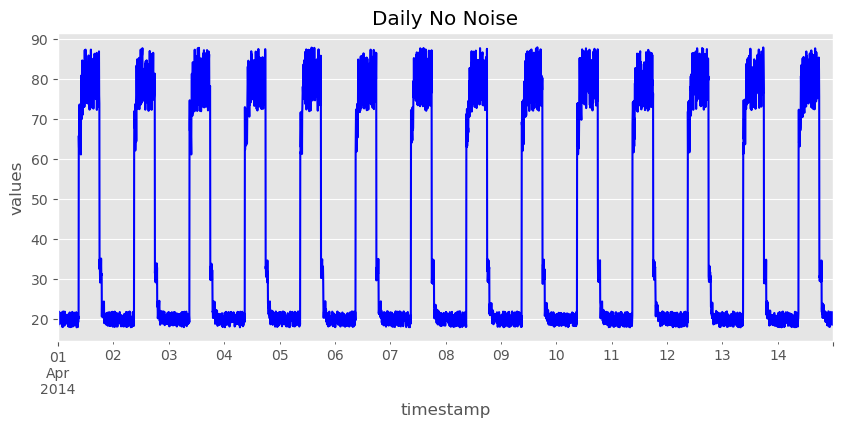

In [52]:
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax, ylabel='values',
                    title='Daily No Noise', color='blue');

In [6]:
# Read the data file with anomaly into a pandas dataframe.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [7]:
# Check the first five rows of the dataframe.
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


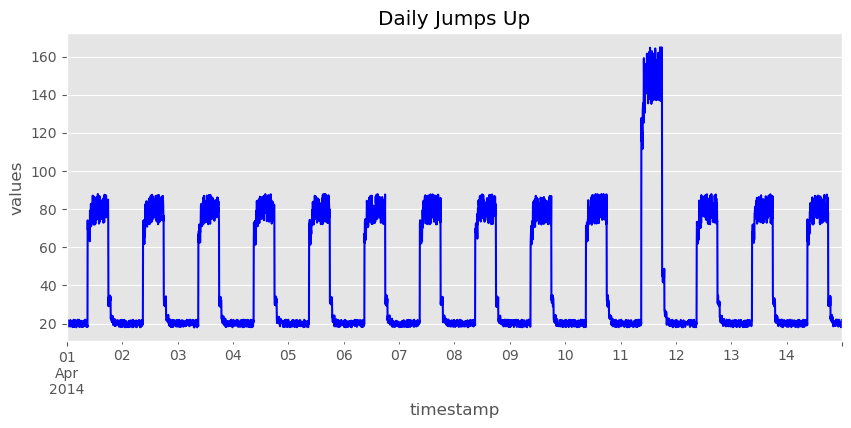

In [53]:
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax, ylabel='values',
                      title='Daily Jumps Up', color='blue');    

<h2 style="color: #001a79;">Exploratory Data Analysis</h2>

<p style="color: #001a79;"> There is very sparse data analysis carried out in the original tutorial on the Keras website. This is to be expected since the whole purpose of the tutorial is to give you an introduction to anomaly detection using Autoencoders. However, in his recent paper "How to avoid machine learning pitfalls: a guide for academic researchers", Michael Lones gives some salient advice.</p>

> It's normal to want to rush into training and evaluating models, but it's important to<br>
take the time to think about the goals of a project, to fully understand the data that<br>
will be used to support these goals, to consider any limitations of the data that need to<br>
be addressed, and to understand what's already been done in your field. If you don't do<br>
these things, then you may end up with results that are hard to publish, or models that<br>
are not appropriate for their intended purpose.
</p>

<p style="color: #001a79;"> In this section, I will carry out some basic Exploratory Data Analysis on the two data sets used in this tutorial. </p>

<hr style="border-top: 1px solid #001a79;" />

In [54]:
# Generate some basics statistics for the small_noise data frame.
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [55]:
# Generate some basics statistics for the daily_jumpsup data frame.
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


<p style="color: #001a79;"> Even from these basic statistics we can see that there is a marginal difference in the mean and standard deviation of the two data sets.<br>
We can also see that the max value for the daily_jumpsup data set is significantly higher than the small_noise data set. </p>
</p>

In [64]:
# Check for missing values in each dataframe.
small_miss = df_small_noise.isnull().sum()
jump_miss = df_daily_jumpsup.isnull().sum()

# Just get the value of the missing values and print to screen.
print(f'There are {small_miss.values[0]} missing values in the small_noise data frame.')
print(f'There are {jump_miss.values[0]} missing values in the daily_jumpsup data frame.')

There are 0 missing values in the small_noise data frame.
There are 0 missing values in the daily_jumpsup data frame.


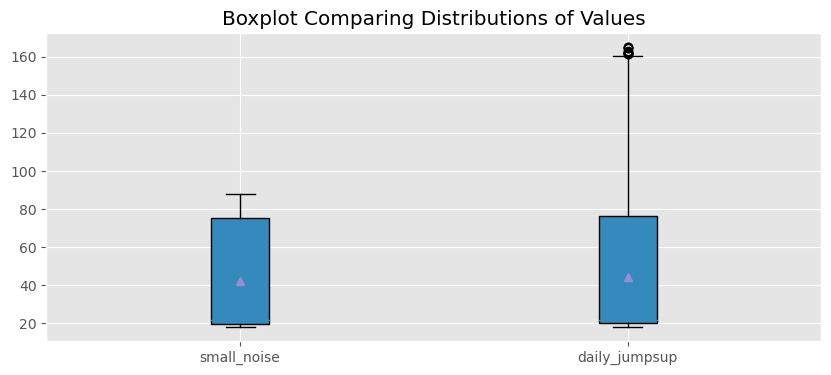

In [59]:
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pyplot to plot the boxplots for each dataframe on the same axis.
plt.boxplot([df_small_noise['value'], df_daily_jumpsup['value']],
            labels=['small_noise', 'daily_jumpsup'],
            showmeans=True, patch_artist=True)
plt.title('Boxplot Comparing Distributions of Values');

<p style="color: #001a79;"> The boxplots above give us a good idea that neither data set follows a normal distribution (since the mean is much greater than the median). However, since we have less than 5000 data points in each data set we can use the Shapiro-Wilk test to prove or disprove the hypothesis.<br><br>
The null hypothesis for the Shapiro-Wilk test is that the data is normally distributed. We will set a significance level of 0.05 meaning, if the returned p-value from the Shapiro-Wilk test is less than 0.05 we will reject the null hypothesis and conclude that the data is not normally distributed</p>


In [76]:
# Importing the Shapiro-Wilk test from scipy.stats.
from scipy.stats import shapiro

# Run Shapiro-Wilk test on small_noise data frame.
stat, p = shapiro(df_small_noise['value'])
print(f'Statistic = {stat:.3f}, p = {p:.3f}')

Statistic = 0.712, p = 0.000


In [77]:
# Run Shapiro-Wilk test on daily_jumpsup data frame.
stat, p = shapiro(df_daily_jumpsup['value'])
print(f'Statistic = {stat:.3f}, p = {p:.3f}')


Statistic = 0.737, p = 0.000


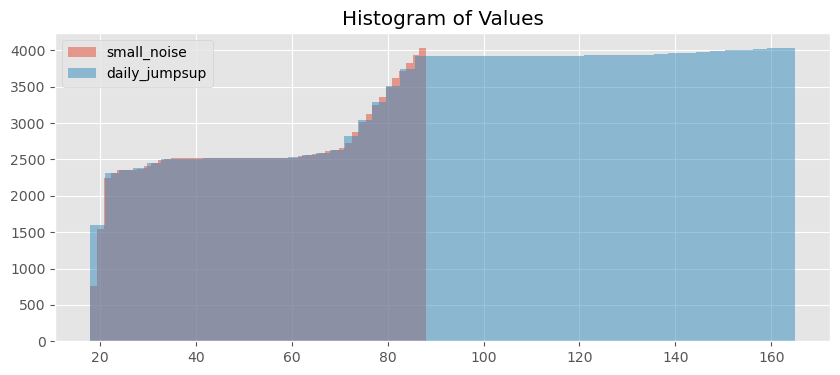

In [68]:
# Plot overlaid histograms of each data set
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pandas to plot overlaid histograms for each dataframe on the same axis.
df_small_noise['value'].hist(bins=50, alpha=0.5, label='small_noise', cumulative=True)
df_daily_jumpsup['value'].hist(bins=50, alpha=0.5, label='daily_jumpsup', cumulative=True)
# Add a legend to the plot.
plt.legend(loc='upper left')
# Add a title to the plot.
plt.title('Cumulative Histogram of Values');


<p style="color: #001a79;"> Both the boxplot and cumulative histogram plot above indicate that the daily_jumpsup dataframe has more outliers than the small_noise dataframe.<br>
Since we are dealing with data which doesn't adhere to the normal distribution we can use the interquartile range method to determine if a point is "statisitically" an outlier or not.<br><br>
From Wikipedia:<br><br></p>

> The interquartile range is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR.
 


In [70]:
def find_outliers_IQR(df):
    """Find outliers in a dataframe using the interquartile range.
    Args:
        df: Pandas dataframe.
        
    Returns:
        A list of the outliers.
    """
    # Get the first and third quartiles.
    q1, q3 = np.percentile(df, [25, 75])
    # Calculate the interquartile range.
    iqr = q3 - q1
    # Calculate the lower bound.
    lower_bound = q1 - (1.5 * iqr)
    # Calculate the upper bound.
    upper_bound = q3 + (1.5 * iqr)
    # Return a list of outliers.
    return df[(df < lower_bound) | (df > upper_bound)].index.tolist()

In [74]:
# Find outliers in the small_noise data frame using function above.
outliers = find_outliers_IQR(df_small_noise['value'])
# Print count of outliers
print(f'There are {len(outliers)} outliers in the small_noise data frame.')

There are 0 outliers in the small_noise data frame.


In [75]:
# Find outliers in the daily_jumpsup data frame using function above.
outliers = find_outliers_IQR(df_daily_jumpsup['value'])
# Print count of outliers
print(f'There are {len(outliers)} outliers in the daily_jumpsup data frame.')

There are 12 outliers in the daily_jumpsup data frame.


<p style="color: #001a79;"> Our outlier detection function has determined that there are 0 "statistical" outliers in the small_noise data set and 12 in the daily_jumpsup data set.<br>
Using a simple time series plot and overlaying the two data sets shows this quite easily (below)</p>

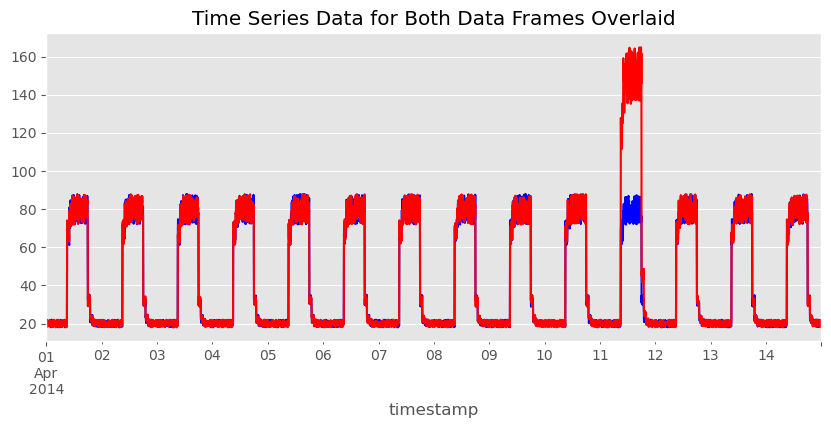

In [80]:
# Create time series data for both data frames overlaid (use dots).
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pandas to plot overlaid time series data for each dataframe on the same axis.
df_small_noise['value'].plot(legend=False, ax=ax, color='blue')
df_daily_jumpsup['value'].plot(legend=False, ax=ax, color='red')
# Add a title to the plot.
plt.title('Time Series Data for Both Data Frames Overlaid');


<p style="color: #001a79;"> Now we have a slightly better understnading of our data. We know that there are no missing values present in either data set. Neither data set is normally distributed. We have outliers in the daily_jumpsup data set but not in the small_noise data set. Our goal is to accurately detect these anomalies.<br><br>
My next question would be: <b>Should we use Machine Learning?</b><br><br>
I know that the entire reason for this project is to deploy the Keras Anomaly Detection using Autoencoders but, to paraphrase Matthew Carbone in his article <a href="https://link.springer.com/article/10.1557/s43577-022-00417-z">When not to use machine learning: A perspective on potential and limitations</a>: Machine Learning is the Jack Hammer of the Data world and can do some incredible things. However you wouldn't use a jack hammer to do brain surgery and there are some problems for which Machine Learning is either unsuited or simply overkill.<br><br>
Let's consider the data once again. We can see that both data sets have the same patterns. There are troughs and peaks separated by a fairly rapid transition between each state. Using the highly technical skill of "eyeballing a chart" we could estimate that the trough for each dataset is between 0 and 40 (consistently) and the peak is typically around around 80 +/-20 (asides from the anomaly period).</p>

In [96]:
# Create a dataframe from daily_jumpsup with
# values between 70 and 170.
df_daily_jumpsup_high = df_daily_jumpsup[(df_daily_jumpsup['value'] > 70) & (df_daily_jumpsup['value'] < 170)]

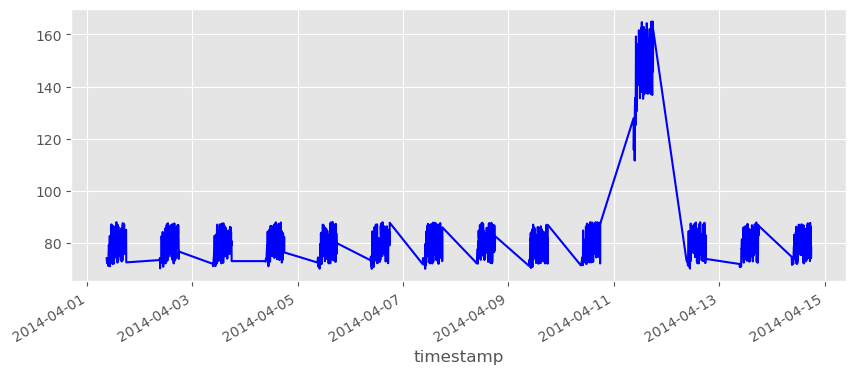

In [97]:
# plot the data
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pandas to plot df_daily_jumpsup_high.
df_daily_jumpsup_high.plot(legend=False, ax=ax, color='blue');



<h2 style="color: #001a79;">When All You Have is a Hammer - Everything Looks Like a Nail</h2>
<p style="color: #001a79;">Now that we have extracted the "peak" part of our data set (including the anomaly) we can consider how we might detect the anomaly (otherwise known as a "Assignable Cause Variation in SPC parlance) without using Machine Learning.<br><br>
The goal in Statistical Process Control is only to react to assignable cause variation. In essence there are two types of variation we see in processes:<br><br>
- Common Cause Variation: Inherent in the system and can only typically be improved by improving the equipment or changing procedures.<br>
- Assignable Cause Variation: Comes from sources outside the system e.g. Equipment malfunction, raw material problems, operator error etc.<br></p>

<p style="color: #001a79;">As we are dealing with continuous data that is not subgrouped we can use an I-MR (Individual - Moving Range) SPC chart to detect Assignable Cause Variation. The I-MR chart is a simple chart that plots the difference between the current value and the previous value. If the difference is greater than a pre-defined limit then the point is considered an "outlier" and is plotted on the chart.</p>

<p style="color: #001a79;">There are specific rules that should be considered when deciding if an I-MR chart is applicable:<br><br>
- The data should be continuous and not subgrouped.<br>
- The data should be in time order.<br>
- The data should be collected at appropriate intervals.<br>
- The data should be individual observations and not averages.<br>
- The data should include at least 100 observations.<br>
- The data should not be heavily skewed.<br>
- The observations should be independent of each other.<br><br>
Reference: <a href="https://support.minitab.com/en-us/minitab/21/help-and-how-to/quality-and-process-improvement/control-charts/how-to/variables-charts-for-individuals/i-mr-chart/before-you-start/data-considerations/">Data considerations for I-MR Chart</a>

</p>

<hr style="border-top: 1px solid #001a79;" />

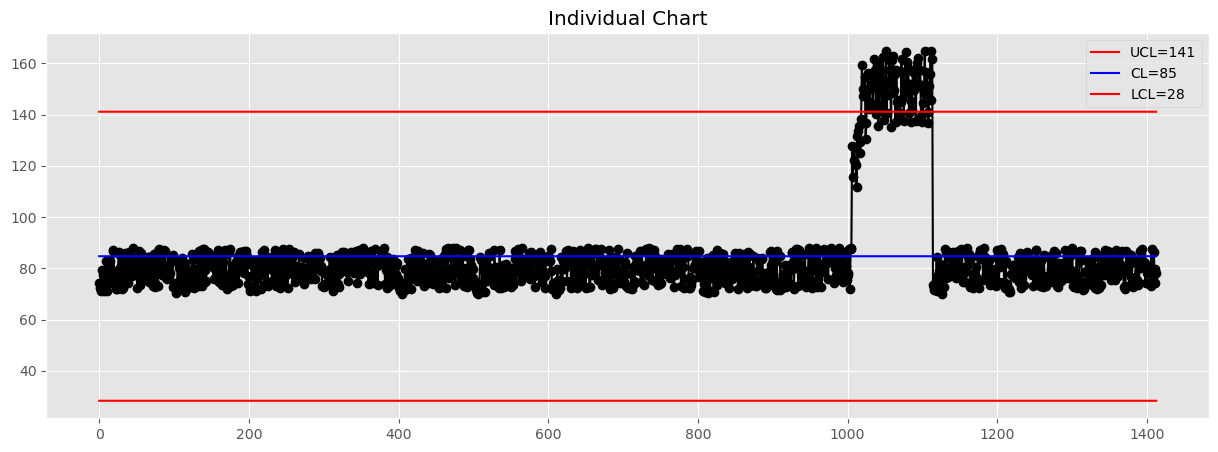

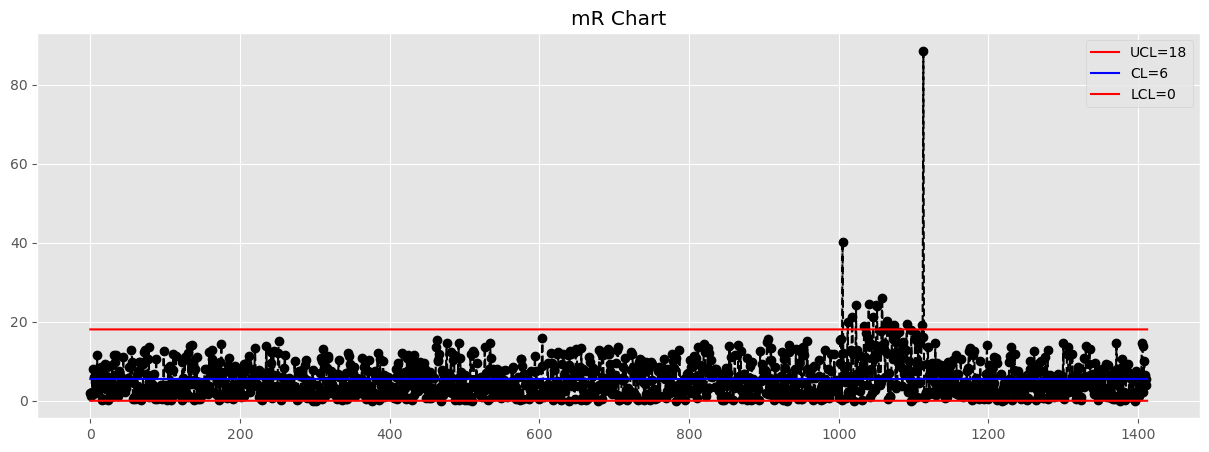

In [112]:
# Code adapted from: https://towardsdatascience.com/push-your-sales-with-statistical-process-control-52321f329405 

class SPC:
    def fit(self,data):
        self.X = data
        # Calculate the number of samples
        self.number_of_sample = len(self.X)
        # Create an array to store the moving range
        self.mR = np.zeros(((self.number_of_sample-1),1))
        # Calculate the moving range length
        for i in range(len(self.mR)):
            self.mR[i] = abs(self.X[i+1] - self.X[i])
    # Function to plot the Individual Bar and Moving Range chart (I / MR)
    def QCC(self):
        # Calculate the upper control limit for Individual Chart (Mean + 3 x standard deviation) 
        ucl_X = self.X.mean() + (3*self.X.std())
        # Calculate the central line for Individual Bar (mean)
        cl_X = self.X.mean()
        # Calculate the lower control limit for Individual Chart (Mean - 3 x standard deviation) 
        lcl_X = self.X.mean() - (3*self.X.std())
        # Calculate the upper control limit for Moving Range
        ucl_mR = 3.267*self.mR.mean()
        # Calculate the central line for Moving Range
        cl_mR = self.mR.mean()
        # Calculate the lower control limit for Moving Range 
        lcl_mR = 1-3*0.853/1.128 if 1-3*0.853/1.128 > 0 else 0

        
        # Plot Individual Bar chart (Chart includes LCL, Mean and UCL)
        plt.figure(figsize=(15,5))
        plt.plot(self.X,marker="o",color="k") 
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_X)) 
        plt.plot([cl_X]*len(self.X),color="b",label="CL={:,.0f}".format(cl_X))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={:,.0f}".format(lcl_X))
        plt.title("Individual Chart")
        plt.legend()
        plt.show()

        # Plot Moving Range chart (Chart includes LCL, Centre line and UCL)
        plt.figure(figsize=(15,5))
        plt.plot(self.mR ,marker="o",color="k", linestyle='--') 
        plt.plot([ucl_mR ]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_mR))
        plt.plot([cl_mR ]*len(self.X),color="b",label="CL={:,.0f}".format(cl_mR))
        plt.plot([lcl_mR ]*len(self.X),color="r",label="LCL={:,.0f}".format(round(lcl_mR,0)))
        plt.title("mR Chart")
        plt.legend()
        plt.show()

plt.style.use('seaborn-colorblind')
# Create an instance of the SPC class      
chart = SPC()
# Fit the daily_jumpsup_high data to the chart
chart.fit(df_daily_jumpsup_high['value'].to_numpy())
# Plot the X Bar and Moving Range chart
chart.QCC() 



<p style="color: #001a79;">Clearly we can detect assignable cause variation (anomalies) using the tried and tested method of Statistical Process Control. We could make the UCL and LCL limits more sensitive (In our example above I used the entire daily_jumpsup_high data set to calculate the limits) which would result in the first anomalous point breaching the upper control limit.<br<br>
What I like about SPC in general is that it is very easy to explain to upper management. Everyone can understand trends and outliers when presented in this method. If necessary I could elaborate on the calculations behind establishing the upper and lower control limits.<br><br>
With Machine Learning and, in particular, Neural Networks I doubt I could explain their workings to my management team!</p>

<hr style="border-top: 1px solid #001a79;" />

<h2 style="color: #001a79;">Preprocessing</h2>
<p style="color: #001a79;">Having illustrated that the anomalies in this particular data set could be detected using SPC and that Machine Learning is not necessarily required for this job, we will proceed with developing a Neural Network!<br><br> </p>

<p style="color: #001a79;">Preprocessing is a critical step in any Machine Learning project. The data must be in a format that the model can understand. We have already determined that there is no missing data in the data sets and there is one single feature: value. Had their been missing data we would have had to decide whether we want to delete all these entries (problematic since it is a time based measurement) or impute the missing data.<br><br>
The second preprocessing technique to consider is data normalization. There are several methods that we could chose from such as:<br><br>
- Min-Max Scaling<br>
- Standardization<br>
- Normalization<br> </p>

<p style="color: #001a79;">In this case we will use Z-score Normalization. This is a simple method that scales the data between based on the mean and standard deviation of the data. The formula is:<br><br></p>

$z = (x - u) / s $
<br><br>

<p style="color: #001a79;">Where:</p><br>

$x$ = value<br>
$u$ = mean<br>
$s$ = standard deviation<br><br>

</p>

<p style="color: #001a79;">Scaling is of particular importance when there are many attributes in the data set with different scales. For example, if we had a data set with the following attributes:<br><br>
- Age (0-20)<br>
- Height (0-2m)<br>
- Weight (0-200kg)<br><br>

</p>


<p style="color: #001a79;">The neural network would be heavily influenced by the weight attribute resulting in the neural network being biased towards it (also known as the <a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">Curse of Dimensionality)</a>.<br><br>
</p>


<hr style="border-top: 1px solid #001a79;" />

In [9]:
# Calculate the mean of the small_noise data frame.
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [10]:
# Calculate the standard deviation of the small_noise data frame.
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [11]:
# Divide mean of small_noise data frame by standard deviation to scale data.
# This is known as Z-score normalization.
df_train_vals = (df_small_noise - train_mean) / train_std

In [113]:
# Check the first 5 rows of the scaled data frame.
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


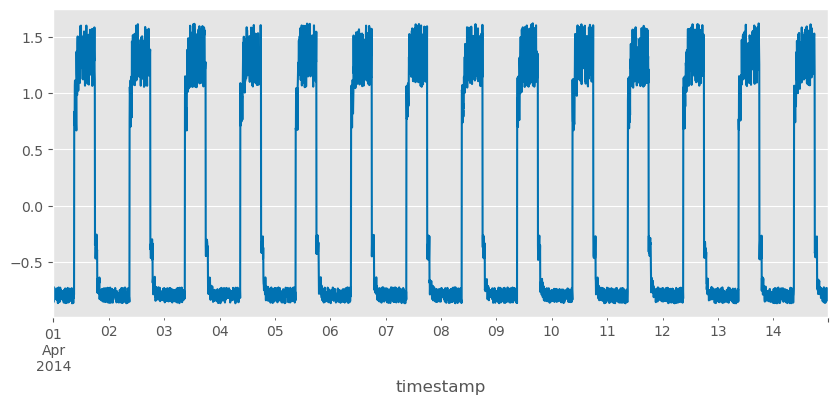

In [114]:
# Create a figure with a size of 10 x 4.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot scaled data frame.
df_train_vals.plot(legend=False, ax=ax);

In [14]:
# Check the number of training samples and shape of array
df_train_vals.shape

(4032, 1)

In [15]:
# Check the columns included in the training data frame. 
df_train_vals.columns

Index(['value'], dtype='object')

<h3 style="color: #001a79;">Window Size Explained</h2>

<p style="color: #001a79;">If we had the following sequence of data:</p>

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
```

<p style="color: #001a79;">And we created a window size of 3 we would get the following:</p>

```python
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
```

<p style="color: #001a79;">The data we are working with is collected at regular intervals. There is one value recorded every 5 minutes throughout the day over a 14 day period.<br>
This results in 288 samples taken over a 24 hour period:</p><br>

$$ 24 * 60 / 5 = 288 $$ 

<br><br>

<p style="color: #001a79;">The window size is the number of samples that are used to predict the next sample. In our training data we are using 288 samples to predict the next sample.<br> The input data to our model is the change in value from the previous 288 time steps, giving us 288 individual input features. <a href="https://medium.com/mindboard/training-recurrent-neural-networks-on-long-sequences-b7a3f2079d49">Reference</a></p>

In [16]:
# Defining window size based on number of measurements per day.
window_size = 288

In [18]:
# Generating training sequences for use in the model.
def windows(vals, N=window_size):
  # Define an empty list (L) to store the sequences.
  L = []
  # Loop through the data frame and create sequences of length N (windows).
  for i in range(len(vals) - N + 1):
    # Append a window to the list.
    L.append(vals[i:i+N])
  # Stack the sequences (windows) in a numpy array.
  return np.stack(L)

In [19]:
# Create windows from the training data frame.
x_train = windows(df_train_vals)

In [117]:
# Print out length of first window.
print(len(x_train[0]))


288


In [20]:
# Check the first and last values of the first window.
x_train[0][0], x_train[0][-1]

(array([-0.85882857]), array([-0.79671155]))

In [120]:
# Print out the shape of the training data.
print(f'The training data has {x_train.shape[0]} windows of {x_train.shape[1]} measurements each.')


The training data has 3745 windows of 288 measurements each.


(3745, 288, 1)

<h2 style="color: #001a79;">Neural Network</h2>
<p style="color: #001a79;">Now that we have preprocessed our training data we can proceed to creating our Neural Network for Anomaly Detection<br> </p>
<h3 style="color: #001a79;">Definitions</h3>
<p style="color: #001a79;">
- Input Layer: <br><br>
We use the input layer to define a tensor for the first layer of the Neural Network.<br>
A tensor is a generalization of vectors and matrices to potentially higher dimensions.<br>
"In the general case, an array of numbers arranged on a regular grid with a variable number of axes is known as a tensor." (Goodfellow, I., Bengio, Y., Courville, A. (2016)) <br>
</p>
<p style="color: #001a79;">
When we define our input layer we are defining the shape of the tensor. In our case we are using a 2D tensor with the shape (288, 1).<br>
Becasue we are creating a sequential model, Keras can automatically infer the shape of the next layer based on the shape of the previous layer. This is why it is essential to get your input layer correct.<br><br>
</p>

<p style="color: #001a79;">
- Conv1D Layer: <br><br>
With normal dense Neural Networks, every node in one layer is connected to every node in the next layer. This is not the case with Convolutional Neural Networks. In a Convolutional Neural Network, each node in one layer is only connected to a small number of nodes in the next layer. <br><br>
The GIF below available at: <a href="https://jinglescode.github.io/2020/11/01/how-convolutional-layers-work-deep-learning-neural-networks/">Jingles Code Github Page</a> shows how a Convolutional layer with a kernel size of 3 works. <br><br>

![Convolution Explained](images\conv2-.gif)

<br><br>
</p>

<p style="color: #001a79;">
Since we are dealing with a time series data set we use a one-dimensional convolutional layer. This is because we are dealing with a single feature (value) over time. <br>
First we specify the number of filters. This is essentially the number of different windows of "kernel_size" we will have.<br>
The kernel size is the size of the sequential window of the input. When we specify a kernel size of 7 we mean that 7 input nodes are operated one at a time passing the result to the next layer. <a href="https://www.databricks.com/glossary/convolutional-layer">Reference</a><br>
Having filters = 32 and kernel_size = 7 means that we are creating 32 different filters each of size (length) 7. <br>
I found it hard to visualise this aspect but found this diagram (adapted from <a href="https://www.researchgate.net/publication/344229502_A_Novel_Deep_Learning_Model_for_the_Detection_and_Identification_of_Rolling_Element-Bearing_Faults">A Novel Deep Learning Model for the Detection and Identification of Rolling Element-Bearing Faults</a>) useful :<br><br><br>
</p>

<img src="images\conv1d.png" alt="1D convolution layer" style="width: 800px;"/>

<br><br>
<p style="color: #001a79;">Padding is used to ensure that the output of the convolutional layer has the same shape as the input. This is done by adding zeros to the input. <br>
Consider the first GIF above, we can see that an input vector of size 6 and kernel size of 3 results in an output vector of size 4. The output has been reshaped.<br>
If we wanted to maintain the same shape we would add zeros to the input vector. This is what padding does. Image courtesy of <a href="https://jinglescode.github.io/2020/11/01/how-convolutional-layers-work-deep-learning-neural-networks/">JinglesCode</a> <br><br>

![Padding](images\padding.gif)

In [124]:
x_train.shape[2]

1

In [23]:
# Creating a sequential model.
layers = [
  # Input layer.
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # Convolutional Layer
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Drop Out Layer
  keras.layers.Dropout(rate=0.2),
  # Convolutional Layer
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

#### Had to install nomkl using the following command: conda install -c conda-forge nomkl

```python

In [24]:
#
model = keras.Sequential(layers)

In [25]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [26]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [28]:
# 
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 7s 225ms/step - loss: 0.4590 - val_loss: 0.0593
Epoch 2/50
27/27 [==============================] - 5s 183ms/step - loss: 0.0846 - val_loss: 0.0409
Epoch 3/50
27/27 [==============================] - 5s 176ms/step - loss: 0.0656 - val_loss: 0.0381
Epoch 4/50
27/27 [==============================] - 5s 191ms/step - loss: 0.0549 - val_loss: 0.0311
Epoch 5/50
27/27 [==============================] - 6s 212ms/step - loss: 0.0454 - val_loss: 0.0272
Epoch 6/50
27/27 [==============================] - 5s 201ms/step - loss: 0.0395 - val_loss: 0.0249
Epoch 7/50
27/27 [==============================] - 6s 209ms/step - loss: 0.0353 - val_loss: 0.0233
Epoch 8/50
27/27 [==============================] - 6s 203ms/step - loss: 0.0320 - val_loss: 0.0235
Epoch 9/50
27/27 [==============================] - 6s 205ms/step - loss: 0.0295 - val_loss: 0.0215
Epoch 10/50
27/27 [==============================] - 5s 203ms/step - loss: 0.0273 - val_loss: 0.0241

## Evaluation

***

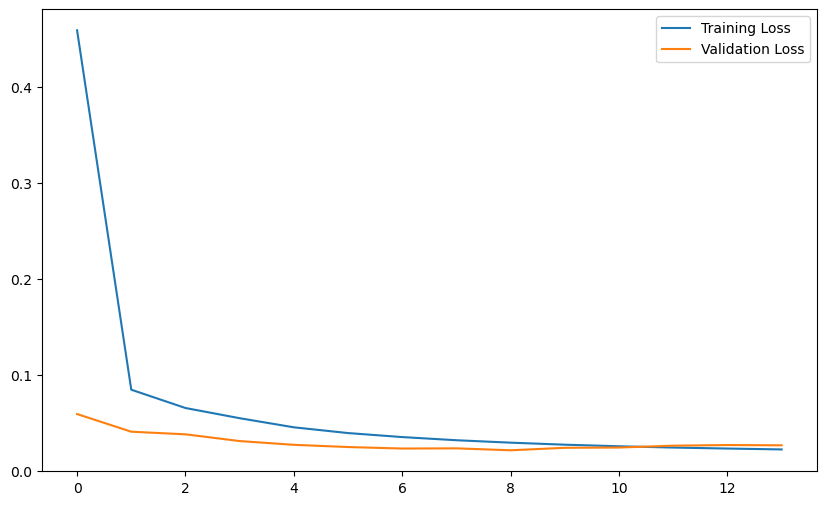

In [29]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

In [30]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 3ms/step


In [31]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

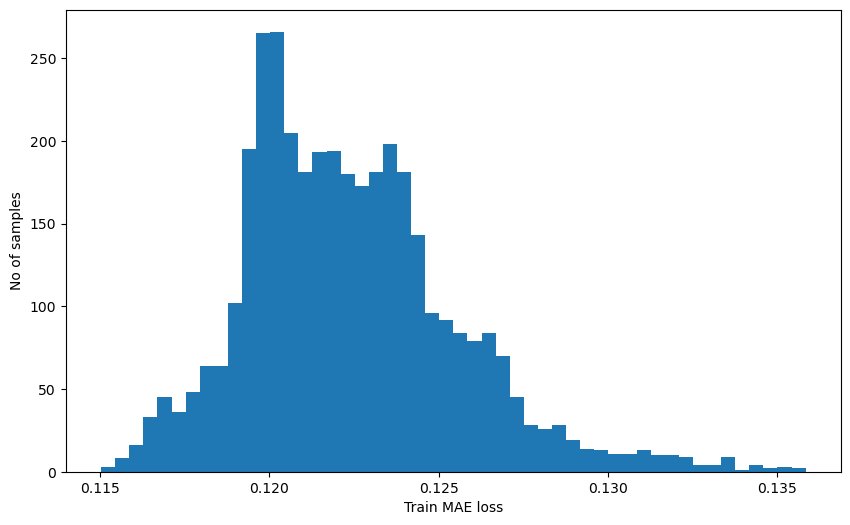

In [32]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [33]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.13585586593409038

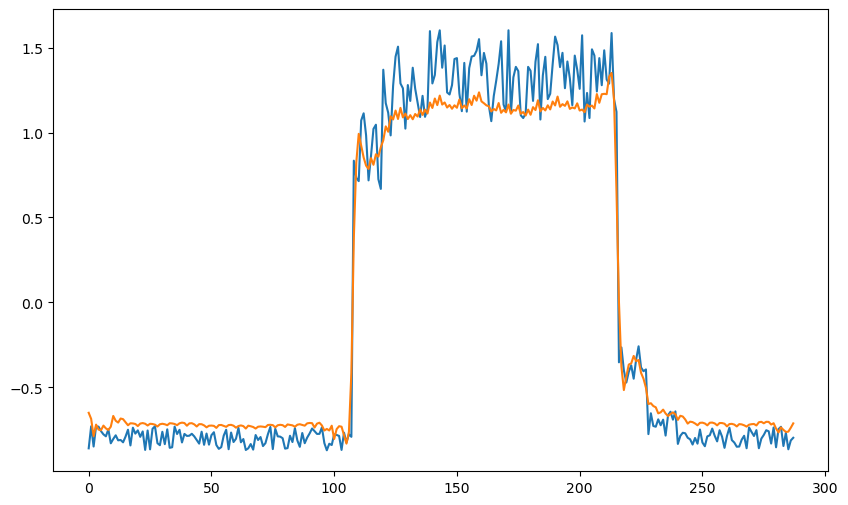

In [34]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [35]:
# Scale the test data using Z-score normalization.
df_test_value = (df_daily_jumpsup - train_mean) / train_std

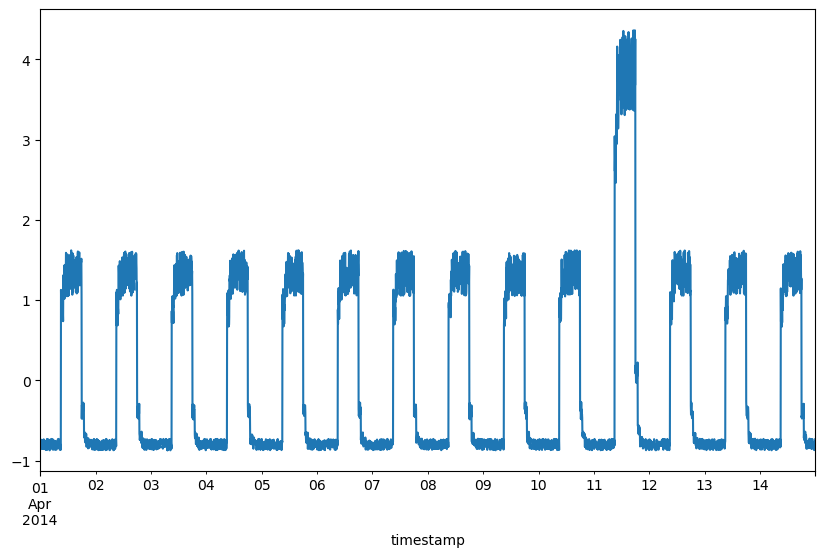

In [36]:
# Create a figure with a size of 10 x 6.
fig, ax = plt.subplots(figsize=(10, 6))

# Use pandas to plot scaled data frame of test data set.
df_test_value.plot(legend=False, ax=ax);

In [37]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [38]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 4ms/step


In [39]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.1182348 ],
       [0.12235065],
       [0.12040408],
       ...,
       [0.11962461],
       [0.12004215],
       [0.11920831]])

In [40]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.1182348 , 0.12235065, 0.12040408, ..., 0.11962461, 0.12004215,
       0.11920831])

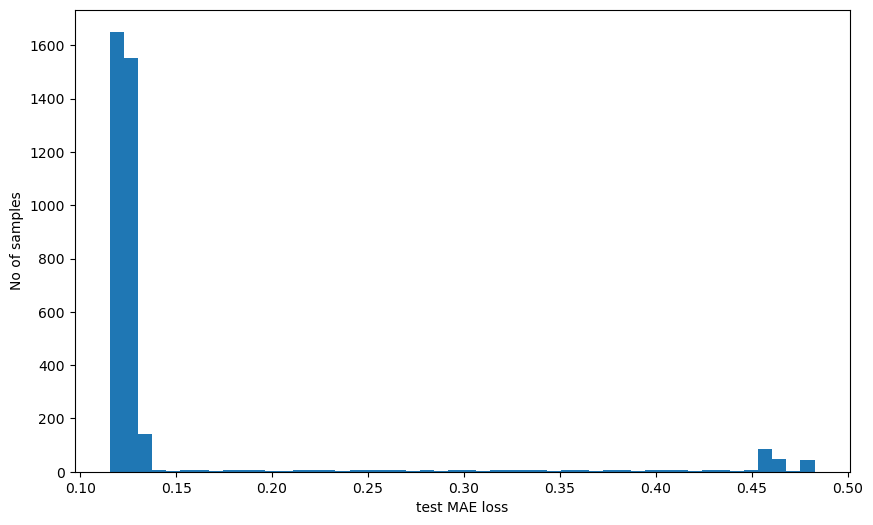

In [41]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [42]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

416

In [43]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [44]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

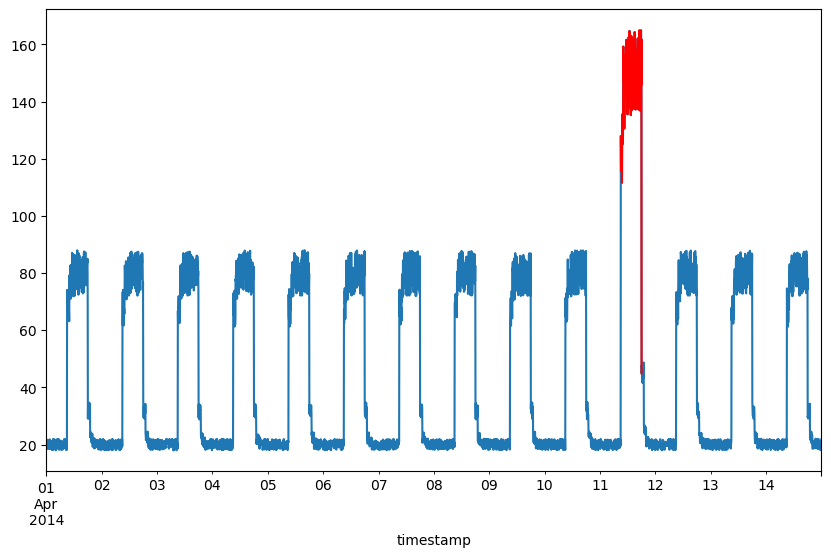

In [45]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");

References:

1. Goodfellow, I.; Bengio, Y. & Courville, A. (2016), Deep Learning , MIT Press.